In [1]:
# all imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
metric = tf.keras.metrics

The new structure of the dataset requires extensive reworking of the code in order to use daily prices instead of rollup information. The code was updated to simplify the label process by using an average momentum score instead of a custom momentum implementaion and explicit labeling of columns was rolled up into loops

In [2]:
# First create new label based on stock performance relative to other stocks and benchmark
# Use the direct path to the file in the environment
input_file = 'sp1500_company_with_history_wide.csv'
benchmark_input_file = 'benchmark_history.csv'
df_raw = pd.read_csv(input_file)

benchmark_df = pd.read_csv(benchmark_input_file, parse_dates=['date'])
# protect against errors when computing pairwise daily returns
benchmark_df = benchmark_df.sort_values('date').reset_index(drop=True)

# convert date to YYYMMDD to match wide column suffixes
benchmark_df['date_key'] = benchmark_df['date'].dt.strftime("%Y%m%d")

# map the date_key to benchmark close price
benchmark_close = benchmark_df.set_index('date_key')['close']

# use log return - measurement of investment performance by ratio of final price to initial price
def log_return(final, initial):
    return np.log(final / initial)


# calculate z score for performance relative to others in each window
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean(skipna=True)
    sd = s.std(ddof=0, skipna=True)
    return (s - mu) / sd

# determine which dates exist in benchmark and company data

all_close_cols = [c for c in df_raw.columns if c.startswith("close_")]

# extract YYYMMDD part from close
company_dates = {c.split("_", 1)[1] for c in all_close_cols}

# keep only dates that are both in benchmark and company history
trade_days = [d for d in benchmark_df['date_key'] if d in company_dates]

# build relative daily returns feature in loop
rel_cols = []

for prev_key, curr_key in zip(trade_days[:-1], trade_days[1:]):
    close_prev = f"close_{prev_key}"
    close_curr = f"close_{curr_key}"

    # name of new feature for relative return
    feature_name = f"rel_ret{curr_key}"

    # stock daily log-return for the day
    stock_ret = log_return(df_raw[close_curr], df_raw[close_prev])

    # benchmark daily log-return for that day
    bench_ret = log_return(benchmark_close[curr_key], benchmark_close[prev_key])


    # relative performance vs benchmark
    df_raw[feature_name] = stock_ret - bench_ret
    rel_cols.append(feature_name)


# now compute z-score for each daily relative-return

z_cols = []

for col in rel_cols:
    z_name = f"z_{col}"
    df_raw[z_name] = zscore(df_raw[col])
    z_cols.append(z_name)


# build 30 day momentum score and label
z_df = df_raw[z_cols].copy()

# simple momentum measure: mean of per-day z-scores
momentum = z_df.mean(axis=1, skipna=True)

pct = momentum.rank(pct=True, method='average')

df_with_label = df_raw.copy()

# add labels based on percentage change
df_with_label['label'] = pd.cut(pct, 
                                bins=[-np.inf, 0.33, 0.66, np.inf],
                                labels=[0, 1, 2])

# drop Nans and cast label to int
df_with_label = df_with_label.dropna(subset=['label']).copy()
df_with_label['label'] = df_with_label['label'].astype('int32')


# add distance to 52 week extremes
rng = (df_with_label['fiftyTwoWeekHigh'] - df_with_label['fiftyTwoWeekLow']).replace(0, np.nan)
df_with_label['pos_in_52w'] = (df_with_label['currentPrice'] - df_with_label['fiftyTwoWeekLow']) / (rng + 1e-9)

# add distance to moving averages
df_with_label['dist_ma50']  = (df_with_label['currentPrice'] - df_with_label['fiftyDayAverage']) / (df_with_label['fiftyDayAverage'] + 1e-9)
df_with_label['dist_ma200'] = (df_with_label['currentPrice'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)
df_with_label['ma_cross']   = (df_with_label['fiftyDayAverage'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)

# add liquidity size, shares outstanding ratios
df_with_label['log_mcap']  = np.log(df_with_label['marketCap'] + 1)
# high outstanding shares = lots of flots is short and performance may be poor
df_with_label['float_to_out'] = df_with_label['floatShares'] / (df_with_label['sharesOutstanding'] + 1e-9)

# add z scores to the table for neural net to see each z score
for z_name in z_cols:
    df_with_label[z_name] = df_raw[z_name]

Now use the same clean data function to clean the data

In [3]:
# now add the new label and clean the dataframe by dropping low value columns

def clean_data(df):
    df_clean = df.copy()
    # remove columns that have no value for analysis, have large amount of
    # missing data
    drop_cols = ['companyOfficers', 'website', 'phone', 'irWebsite',
                 'longBusinessSummary', 'address1', 'tradeable', 'quoteType',
                 'language', 'region', 'quoteSourceName', 'triggerable', 
                 'customPriceAlertConfidence', 'marketState',
                 'exchangeDataDelayedBy', 'sourceInterval', 'cryptoTradeable',
                 'shortName', 'longName', 'hasPrePostMarketData',
                 'corporateActions', 'messageBoardId', 'exchangeTimezoneName',
                 'exchangeTimezoneShortName', 'gmtOffSetMilliseconds', 'fax',
                 'market', 'esgPopulated', 'address2', 'displayName',
                 'ipoExpectedDate', 'prevName', 'nameChangeDate',
                 'industrySymbol', 'trailingPegRatio', 'lastSplitDate', 
                 'lastSplitFactor']

    df_clean.drop(drop_cols, inplace=True, axis=1)
    return df_clean

df_cleaned = clean_data(df_with_label)
# show label column
print(df_cleaned['label'].head(20))
# show all columns
print(df_cleaned.columns.tolist())


0     2
1     0
2     1
3     2
4     2
5     1
6     2
7     1
8     1
9     2
10    0
11    2
12    2
13    2
14    0
15    2
16    0
17    1
18    1
19    2
Name: label, dtype: int32
['city', 'state', 'zip', 'country', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'fullTimeEmployees', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'executiveTeam', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'allTimeHigh', 'allTimeLow', 'priceToS

Make adjustments to feature processing to keep time series columns separate from this first pipeline and not run it through a column transformer to leave the data. Need to make the time series data go in as a multi cahnel input.

In [4]:
# get all the time series columns we care about
prefix_groups = {
    "open": "open_",
    "close": "close_",
    "high": "high_",
    "low": "low_",
    "volume": "volume_",
    "vwap": "vwap_",
    "rel_ret": "rel_ret",
    "z_rel_ret": "z_rel_ret"
}
ts_cols_by_group = {}
for name, pref in prefix_groups.items():
    cols = [c for c in df_cleaned.columns if c.startswith(pref)]
    # sort by date suffix so time axis is ordered
    cols = sorted(cols, key=lambda c: c.split('_')[-1])
    ts_cols_by_group[name] = cols

# trim timesetp to the minimum timestep in the groups
min_timesteps = min(len(cols) for cols in ts_cols_by_group.values())
for name, cols in ts_cols_by_group.items():
    ts_cols_by_group[name] = cols[-min_timesteps:]

# flatten all time-series columns into a list to drop them
ts_all_cols = [c for cols in ts_cols_by_group.values() for c in cols]

target = df_cleaned['label']
# static features are everything except label, symbol, and all time-series
static_features = df_cleaned.drop(columns=['label', 'symbol'] + ts_all_cols)

X_train_static, X_test_static, y_train, y_test = train_test_split(
    static_features,
    target,
    test_size=0.2,
    random_state=44)

# convert target labels to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# PROCESS THE STATIC FEATURES FIRST

# identify all numerical and categorical columns in the static train df
num_features = X_train_static.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train_static.select_dtypes(include=['object']).columns

# define a pipeline for numerical imputing and min max scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])  # scale numerical features so no neg values

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# define processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'
)

# fit only on train to avoid data leakage
X_train_static_proc = preprocessor.fit_transform(X_train_static).toarray()

# use only transform on test data to prevent data leakage
X_test_static_proc = preprocessor.transform(X_test_static).toarray()


# Now we can process the multi-channel time-series input for Conv1D
# get the same indices that we split on before
train_idx = X_train_static.index
test_idx = X_test_static.index

def make_ts_block(cols, train_idx, test_idx):
    # extract, scale, and return time series block for prefix
    X_train_block = df_cleaned.loc[train_idx, cols]
    X_test_block = df_cleaned.loc[test_idx, cols]
    
    # use standard scaler for time series blocks
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_block)
    X_test_scaled = scaler.transform(X_test_block)
    return X_train_scaled, X_test_scaled, scaler

ts_train_blocks = []
ts_test_blocks = []
scalers_ts = {}

for name, cols in ts_cols_by_group.items():
    # get the train, test, and scaler for the block
    X_tr_block, X_te_block, scaler = make_ts_block(cols, train_idx, test_idx)
    scalers_ts[name] = scaler
    ts_train_blocks.append(X_tr_block)
    ts_test_blocks.append(X_te_block)

# get the timesteps for the groups
n_timesteps = ts_train_blocks[0].shape[1]
n_train = ts_train_blocks[0].shape[0]
n_test = ts_test_blocks[0].shape[0]
n_channels = len(ts_train_blocks)

# reshape each block to (batch, timesteps, 1) and stack as channels
train_channels = [block.reshape(n_train, n_timesteps, 1) for block in ts_train_blocks]
test_channels = [block.reshape(n_test, n_timesteps, 1) for block in ts_test_blocks]

X_train_ts = np.concatenate(train_channels, axis=2)
X_test_ts = np.concatenate(test_channels, axis=2)

# model can now take dual input for static and timeseries input

Now that we have two inputs, one for timeseries data and one for static data we can begin creating our convoluted neural network

In [6]:
from sklearn.utils.class_weight import compute_class_weight
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]

# add class weights
classes = np.unique(y_train)   # should be [0, 1, 2]
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight = dict(zip(classes, class_weights_arr))

# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal')(ts_input)
ts_branch = layers.MaxPooling1D(pool_size=2)(ts_branch)
ts_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal')(ts_branch)
ts_branch = layers.Dropout(0.1)(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
static_branch = layers.Dense(256, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(static_input)
static_branch = layers.Dropout(0.2)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(128, activation='relu')(merged)
merged = layers.Dropout(0.3)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=2
)


Epoch 1/30


2025-11-17 20:04:50.247257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 - 4s - 195ms/step - acc: 0.3583 - loss: 1.1566 - prec_neutral: 0.6757 - prec_over: 1.0000 - prec_under: 0.9545 - rec_neutral: 0.0279 - rec_over: 0.0662 - rec_under: 0.0252 - top2_acc: 0.6750 - val_acc: 0.3887 - val_loss: 1.1005 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7409
Epoch 2/30
19/19 - 1s - 35ms/step - acc: 0.4867 - loss: 1.0485 - prec_neutral: 0.7945 - prec_over: 0.8000 - prec_under: 0.8673 - rec_neutral: 0.0604 - rec_over: 0.0266 - rec_under: 0.0843 - top2_acc: 0.7892 - val_acc: 0.4551 - val_loss: 1.0742 - val_prec_neutral: 0.8000 - val_prec_over: 0.5833 - val_prec_under: 0.3333 - val_rec_neutral: 0.0231 - val_rec_over: 0.0809 - val_rec_under: 0.0058 - val_top2_acc: 0.7608
Epoch 3/30
19/19 - 1s - 36ms/step - acc: 0.5625 - loss: 0.9644 - prec_neutral: 0.6400 - prec_over: 0.6779 - prec_under: 0.7258 - rec_neutral: 0.1154 - rec

10/10 - 0s - 45ms/step - acc: 0.5382 - loss: 1.0034 - prec_neutral: 0.7742 - prec_over: 0.6437 - prec_under: 0.8400 - rec_neutral: 0.1171 - rec_over: 0.2917 - rec_under: 0.3544 - top2_acc: 0.8173
loss: 1.0034
compile_metrics: 0.5382
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1: 0.5196
Weighted F1: 0.5155
              precision    recall  f1-score   support

       under       0.54      0.75      0.63        93
     neutral       0.43      0.25      0.32       104
        over       0.59      0.63      0.61       104

    accuracy                           0.54       301
   macro avg       0.52      0.55      0.52       301
weighted avg       0.52      0.54      0.52       301

[[70 13 10]
 [42 26 36]
 [17 21 66]]


<Axes: >

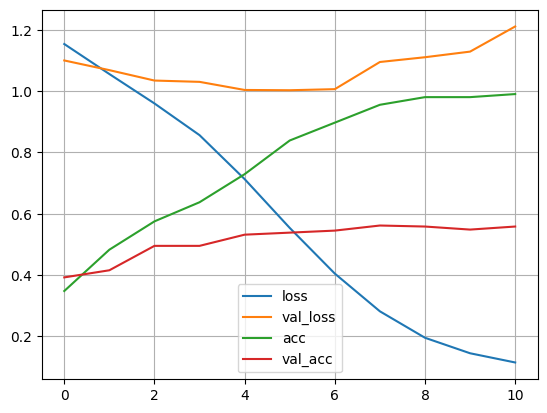

In [51]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))
pd.DataFrame(history.history)[['loss', 'val_loss', 'acc', 'val_acc']].plot(grid=True)

Model is massively overfitting so we will make adjustments

In [52]:
from sklearn.utils.class_weight import compute_class_weight
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]

# add class weights
classes = np.unique(y_train)   # should be [0, 1, 2]
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight = dict(zip(classes, class_weights_arr))

# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add batch normalization to ts branch and remove max pooling
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='causal')(ts_input)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='causal')(ts_branch)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)
ts_branch = layers.Dropout(0.1)(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization()(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(static_branch)
static_branch = layers.Dropout(0.2)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(128, activation='relu')(merged)
merged = layers.Dropout(0.3)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=2
)


Epoch 1/30
19/19 - 8s - 408ms/step - acc: 0.4175 - loss: 1.1596 - prec_neutral: 0.7160 - prec_over: 0.6419 - prec_under: 0.5985 - rec_neutral: 0.2212 - rec_over: 0.2088 - rec_under: 0.2061 - top2_acc: 0.7492 - val_acc: 0.4186 - val_loss: 1.0880 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7575
Epoch 2/30
19/19 - 1s - 61ms/step - acc: 0.6217 - loss: 0.8698 - prec_neutral: 0.6545 - prec_over: 0.5816 - prec_under: 0.6194 - rec_neutral: 0.2163 - rec_over: 0.2429 - rec_under: 0.2553 - top2_acc: 0.8708 - val_acc: 0.4319 - val_loss: 1.0712 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.4286 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0173 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7708
Epoch 3/30
19/19 - 1s - 52ms/step - acc: 0.7108 - loss: 0.7195 - prec_neutral: 0.6678 - prec_over: 0.5799 - prec_under: 0.6176 

In [53]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))



10/10 - 1s - 89ms/step - acc: 0.5482 - loss: 0.9906 - prec_neutral: 0.6400 - prec_over: 0.6712 - prec_under: 0.7143 - rec_neutral: 0.0780 - rec_over: 0.2552 - rec_under: 0.1266 - top2_acc: 0.8073
loss: 0.9906
compile_metrics: 0.5482
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Macro F1: 0.5409
Weighted F1: 0.5390
              precision    recall  f1-score   support

       under       0.63      0.56      0.59        93
     neutral       0.45      0.36      0.40       104
        over       0.55      0.73      0.63       104

    accuracy                           0.55       301
   macro avg       0.55      0.55      0.54       301
weighted avg       0.54      0.55      0.54       301

[[52 22 19]
 [25 37 42]
 [ 5 23 76]]


Performance slightly improved but model is still massively overfitting, add more regularization to every dense and conv1d layer and lower learning rate

In [59]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add batch normalization to ts branch and remove max pooling
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal')(ts_input)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal')(ts_branch)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)
ts_branch = layers.Dropout(0.1)(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization()(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(static_branch)
static_branch = layers.Dropout(0.2)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dropout(0.3)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30
19/19 - 7s - 377ms/step - acc: 0.3525 - loss: 1.3231 - prec_neutral: 0.7100 - prec_over: 0.6171 - prec_under: 0.6434 - rec_neutral: 0.1971 - rec_over: 0.2358 - rec_under: 0.2088 - top2_acc: 0.6950 - val_acc: 0.3555 - val_loss: 1.1518 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6412
Epoch 2/30
19/19 - 1s - 63ms/step - acc: 0.4192 - loss: 1.2037 - prec_neutral: 0.7207 - prec_over: 0.6078 - prec_under: 0.6104 - rec_neutral: 0.1923 - rec_over: 0.2443 - rec_under: 0.1875 - top2_acc: 0.7267 - val_acc: 0.3455 - val_loss: 1.1418 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6744
Epoch 3/30
19/19 - 1s - 53ms/step - acc: 0.4542 - loss: 1.1460 - prec_neutral: 0.7224 - prec_over: 0.5956 - prec_under:

In [60]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))



10/10 - 1s - 86ms/step - acc: 0.5415 - loss: 1.0055 - prec_neutral: 0.7297 - prec_over: 0.6071 - prec_under: 0.8060 - rec_neutral: 0.1317 - rec_over: 0.1771 - rec_under: 0.2278 - top2_acc: 0.8339
loss: 1.0055
compile_metrics: 0.5415
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Macro F1: 0.5427
Weighted F1: 0.5415
              precision    recall  f1-score   support

       under       0.54      0.61      0.58        93
     neutral       0.44      0.42      0.43       104
        over       0.65      0.60      0.62       104

    accuracy                           0.54       301
   macro avg       0.54      0.54      0.54       301
weighted avg       0.54      0.54      0.54       301

[[57 29  7]
 [34 44 26]
 [14 28 62]]


Still overfitting, will try adding max pooling, and adjusting the layer sizes and dropout in time series branch

In [ ]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add max pooling
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal')(ts_input)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.MaxPooling1D(pool_size=2)(ts_branch)
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal')(ts_branch)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)
ts_branch = layers.Dropout(0.15)(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization()(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(static_branch)
static_branch = layers.Dropout(0.2)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dropout(0.3)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30
19/19 - 8s - 414ms/step - acc: 0.3408 - loss: 1.4399 - prec_neutral: 0.6779 - prec_over: 0.6047 - prec_under: 0.6293 - rec_neutral: 0.2175 - rec_over: 0.2216 - rec_under: 0.2168 - top2_acc: 0.6592 - val_acc: 0.3821 - val_loss: 1.1532 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7409
Epoch 2/30
19/19 - 2s - 80ms/step - acc: 0.4092 - loss: 1.2539 - prec_neutral: 0.6880 - prec_over: 0.6171 - prec_under: 0.5932 - rec_neutral: 0.2067 - rec_over: 0.2358 - rec_under: 0.2074 - top2_acc: 0.7442 - val_acc: 0.3854 - val_loss: 1.1420 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7375
Epoch 3/30
19/19 - 1s - 57ms/step - acc: 0.4533 - loss: 1.1936 - prec_neutral: 0.6721 - prec_over: 0.6107 - prec_under:

In [64]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))



10/10 - 1s - 98ms/step - acc: 0.5449 - loss: 0.9689 - prec_neutral: 0.7121 - prec_over: 0.5972 - prec_under: 0.8310 - rec_neutral: 0.2293 - rec_over: 0.2240 - rec_under: 0.2489 - top2_acc: 0.8605
loss: 0.9689
compile_metrics: 0.5449
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Macro F1: 0.5481
Weighted F1: 0.5459
              precision    recall  f1-score   support

       under       0.61      0.61      0.61        93
     neutral       0.41      0.42      0.42       104
        over       0.63      0.61      0.62       104

    accuracy                           0.54       301
   macro avg       0.55      0.55      0.55       301
weighted avg       0.55      0.54      0.55       301

[[57 30  6]
 [29 44 31]
 [ 8 33 63]]


Slight improvement, will now adjust the dense layer after merge to add another layer

In [73]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add batch normalization to ts branch and remove max pooling
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal')(ts_input)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.SpatialDropout1D(0.1)(ts_branch)
ts_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal')(ts_branch)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.MaxPooling1D(pool_size=2)(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)
ts_branch = layers.Dropout(0.15)(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization()(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(96, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(5e-4))(static_branch)
static_branch = layers.Dropout(0.25)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(48, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(merged)
merged = layers.Dropout(0.15)(merged)
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dropout(0.1)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30
19/19 - 9s - 476ms/step - acc: 0.3258 - loss: 1.4038 - prec_neutral: 0.6703 - prec_over: 0.6171 - prec_under: 0.6212 - rec_neutral: 0.2224 - rec_over: 0.1534 - rec_under: 0.1636 - top2_acc: 0.6542 - val_acc: 0.3555 - val_loss: 1.2328 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7010
Epoch 2/30
19/19 - 1s - 77ms/step - acc: 0.3925 - loss: 1.3108 - prec_neutral: 0.6910 - prec_over: 0.6193 - prec_under: 0.6462 - rec_neutral: 0.1935 - rec_over: 0.1548 - rec_under: 0.1676 - top2_acc: 0.7117 - val_acc: 0.3920 - val_loss: 1.2251 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7276
Epoch 3/30
19/19 - 1s - 60ms/step - acc: 0.4100 - loss: 1.2598 - prec_neutral: 0.6653 - prec_over: 0.5767 - prec_under:

In [74]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))



10/10 - 1s - 114ms/step - acc: 0.5316 - loss: 1.0827 - prec_neutral: 0.6981 - prec_over: 0.6324 - prec_under: 0.8143 - rec_neutral: 0.1805 - rec_over: 0.2240 - rec_under: 0.2405 - top2_acc: 0.8106
loss: 1.0827
compile_metrics: 0.5316
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Macro F1: 0.5311
Weighted F1: 0.5300
              precision    recall  f1-score   support

       under       0.57      0.56      0.56        93
     neutral       0.43      0.41      0.42       104
        over       0.59      0.62      0.61       104

    accuracy                           0.53       301
   macro avg       0.53      0.53      0.53       301
weighted avg       0.53      0.53      0.53       301

[[52 26 15]
 [31 43 30]
 [ 9 30 65]]


In [8]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="ts_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add batch normalization to ts branch
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal')(ts_input)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.SpatialDropout1D(0.1)(ts_branch)
ts_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal')(ts_branch)
ts_branch = layers.BatchNormalization()(ts_branch)
ts_branch = layers.MaxPooling1D(pool_size=2)(ts_branch)
ts_branch = layers.GlobalAveragePooling1D()(ts_branch)
ts_branch = layers.Dropout(0.15)(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,))
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization()(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(static_branch)
static_branch = layers.Dropout(0.2)(static_branch)
# merge branches
merged = layers.Concatenate()([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dropout(0.3)(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30
19/19 - 5s - 240ms/step - acc: 0.3542 - loss: 1.4168 - prec_neutral: 0.6548 - prec_over: 0.6043 - prec_under: 0.7709 - rec_neutral: 0.1581 - rec_over: 0.2442 - rec_under: 0.2830 - top2_acc: 0.6817 - val_acc: 0.3355 - val_loss: 1.1662 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6977
Epoch 2/30
19/19 - 1s - 42ms/step - acc: 0.4492 - loss: 1.2010 - prec_neutral: 0.7672 - prec_over: 0.6220 - prec_under: 0.6486 - rec_neutral: 0.1510 - rec_over: 0.2357 - rec_under: 0.2331 - top2_acc: 0.7517 - val_acc: 0.3555 - val_loss: 1.1567 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7043
Epoch 3/30
19/19 - 1s - 43ms/step - acc: 0.4483 - loss: 1.1492 - prec_neutral: 0.5628 - prec_over: 0.6000 - prec_under:

In [9]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))



10/10 - 0s - 49ms/step - acc: 0.5249 - loss: 1.0216 - prec_neutral: 0.6111 - prec_over: 0.6769 - prec_under: 0.8039 - rec_neutral: 0.1610 - rec_over: 0.2292 - rec_under: 0.1730 - top2_acc: 0.8272
loss: 1.0216
compile_metrics: 0.5249
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Macro F1: 0.5269
Weighted F1: 0.5249
              precision    recall  f1-score   support

       under       0.59      0.58      0.58        93
     neutral       0.38      0.38      0.38       104
        over       0.61      0.62      0.61       104

    accuracy                           0.52       301
   macro avg       0.53      0.53      0.53       301
weighted avg       0.52      0.52      0.52       301

[[54 33  6]
 [29 40 35]
 [ 9 31 64]]


Performance is worse so we will try two more changes before sticking with the last model we had with the best performance
Attempt to increase weight of neutral class

In [12]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="time_series_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add max pooling
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal',
                          name='convo_layer_1')(ts_input)
ts_branch = layers.BatchNormalization(name='convo_batch_norm_1')(ts_branch)
ts_branch = layers.MaxPooling1D(pool_size=2, name='max_pooling')(ts_branch)
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal',
                          name='convo_layer_2')(ts_branch)
ts_branch = layers.BatchNormalization(name='convo_batch_norm_2')(ts_branch)
ts_branch = layers.GlobalAveragePooling1D(name='global_average_pooling')(ts_branch)
ts_branch = layers.Dropout(0.15, name='convo_dropout')(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,), name='static_input')
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization(name='static_batch_norm')(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                             name='static_dense_layer')(static_branch)
static_branch = layers.Dropout(0.2, name='static_dropout')(static_branch)
# merge branches
merged = layers.Concatenate(name='merge')([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(64, activation='relu', name='merged_dense_layer')(merged)
merged = layers.Dropout(0.3, name='merged_dropout')(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)

# add neutral class weighting

class_weight = {
    0: 1.0,   # under
    1: 1.3,   # neutral (slightly up-weighted)
    2: 1.0    # over
}

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=2
)




Epoch 1/30
19/19 - 5s - 281ms/step - acc: 0.3467 - loss: 1.5896 - prec_neutral: 0.6084 - prec_over: 0.6163 - prec_under: 0.5425 - rec_neutral: 0.2500 - rec_over: 0.2070 - rec_under: 0.2594 - top2_acc: 0.6667 - val_acc: 0.3621 - val_loss: 1.1420 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6977
Epoch 2/30
19/19 - 1s - 51ms/step - acc: 0.3900 - loss: 1.4218 - prec_neutral: 0.7774 - prec_over: 0.6908 - prec_under: 0.5664 - rec_neutral: 0.2331 - rec_over: 0.2057 - rec_under: 0.2266 - top2_acc: 0.7267 - val_acc: 0.3688 - val_loss: 1.1340 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7143
Epoch 3/30
19/19 - 1s - 48ms/step - acc: 0.4517 - loss: 1.3163 - prec_neutral: 0.8000 - prec_over: 0.6174 - prec_under:

10/10 - 1s - 55ms/step - acc: 0.5349 - loss: 1.0004 - prec_neutral: 0.6809 - prec_over: 0.6600 - prec_under: 0.7692 - rec_neutral: 0.3122 - rec_over: 0.1719 - rec_under: 0.1688 - top2_acc: 0.8405
loss: 1.0004
compile_metrics: 0.5349
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Macro F1: 0.5409
Weighted F1: 0.5404
              precision    recall  f1-score   support

       under       0.60      0.52      0.55        93
     neutral       0.42      0.59      0.49       104
        over       0.68      0.50      0.58       104

    accuracy                           0.53       301
   macro avg       0.57      0.53      0.54       301
weighted avg       0.57      0.53      0.54       301

[[48 40  5]
 [24 61 19]
 [ 8 44 52]]


<Axes: >

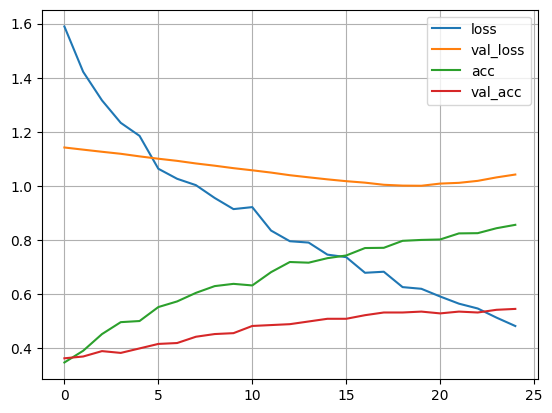

In [13]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))
pd.DataFrame(history.history)[['loss', 'val_loss', 'acc', 'val_acc']].plot(grid=True)

Now save the model and get the stocks that are most likely to outperform in the next trading day

In [28]:
# save final manual model
import joblib
model_conv_ts_static.save("nn_conv_outperf.h5")
joblib.dump(preprocessor, "preprocessor.pkl")

# Save time-series metadata & scalers used during training
joblib.dump(ts_cols_by_group, "ts_cols_by_group.pkl")  # dict: group -> column names
joblib.dump(scalers_ts, "scalers_ts.pkl")              # dict: group -> StandardScaler

final_model = tf.keras.models.load_model('nn_conv_outperf.h5')
preproc = joblib.load("preprocessor.pkl")
ts_cols_by_group = joblib.load("ts_cols_by_group.pkl")
scalers_ts = joblib.load("scalers_ts.pkl")

df_live = df_cleaned.copy()

# Build the list of all time-series columns (same logic as training)
ts_all_cols = [c for cols in ts_cols_by_group.values() for c in cols]

# STATIC FEATURES: drop label, symbol, and all time-series columns
static_live = df_live.drop(columns=['label', 'symbol'] + ts_all_cols, errors='ignore')

# Apply static preprocessor
X_live_static_proc = preproc.transform(static_live)
# If your preprocessor returns sparse matrix, convert to dense
if not isinstance(X_live_static_proc, np.ndarray):
    X_live_static_proc = X_live_static_proc.toarray()

# TIME-SERIES FEATURES: build (n_samples, timesteps, n_channels)
ts_live_blocks = []

for name, cols in ts_cols_by_group.items():
    scaler = scalers_ts[name]
    block = df_live[cols]                # shape: (n_samples, timesteps)
    block_scaled = scaler.transform(block)
    ts_live_blocks.append(block_scaled)

n_samples = ts_live_blocks[0].shape[0]
n_timesteps = ts_live_blocks[0].shape[1]

# reshape each block to (batch, timesteps, 1) and stack as channels
live_channels = [b.reshape(n_samples, n_timesteps, 1) for b in ts_live_blocks]
X_live_ts = np.concatenate(live_channels, axis=2)   # (n_samples, timesteps, n_channels)

# --- predict probabilities over classes ---
# model already outputs softmax probabilities, no need for tf.nn.softmax
probs = final_model.predict([X_live_ts, X_live_static_proc])

p_under = probs[:, 0]
p_neut  = probs[:, 1]
p_over  = probs[:, 2]

# rank the scores
df_live['p_over'] = p_over
df_live['margin_over_vs_next'] = df_live['p_over'] - np.maximum(p_neut, p_under)
df_live['over_confidence'] = df_live[['p_over', 'margin_over_vs_next']].mean(axis=1)

# selection rules
p_threshold = 0.60
stock_picks = df_live.loc[df_live['p_over'] >= p_threshold].copy()
top_5 = stock_picks.sort_values('over_confidence', ascending=False).head(5)

# print the top 5 and some key metrics
print(top_5[['symbol', 'over_confidence', 'recommendationKey', 'currentPrice', 'forwardPE']])

# print top 5 to underperform
df_live['p_under'] = p_under
df_live['margin_under_vs_next'] = df_live['p_under'] - np.maximum(p_neut, p_over)
df_live['under_confidence'] = df_live[['p_under', 'margin_under_vs_next']].mean(axis=1)

p_threshold = 0.6
bottom_picks = df_live.loc[df_live['p_under'] >= p_threshold].copy()
bottom_5 = bottom_picks.sort_values('under_confidence', ascending=False).head(5)

print(df_live[['p_under', 'margin_under_vs_next']].head())

print(bottom_5[['symbol', 'under_confidence','recommendationKey', 'currentPrice', 'forwardPE']])

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    symbol  over_confidence recommendationKey  currentPrice  forwardPE
331   NFLX         0.983647               buy       1112.17  46.769135
957   ARWR         0.927669               buy         41.26  -9.777251
91     COR         0.923780               buy        361.94  22.123470
308    MRK         0.923482               buy         92.92   9.885107
264    JNJ         0.914200               buy        195.93  18.483961
    p_under  margin_under_vs_next
0  0.073268             -0.412959
1  0.163022             -0.556540
2  0.067744             -0.556890
3  0.160065             -0.568843
4  0.449732             -0.003156
     symbol  under_confidence recommendationKey  currentPrice  forwardPE
1427   THRY          0.966578               buy          5.88   7.000000
1318   PLAY          0.960635               buy         14.15   3.803763
346     NVR          0.920910              none       7271.89  14.037044
1284    NWL          0.910765          

In [15]:
# show model architecture
model_conv_ts_static.summary()


Model: "conv1d_ts_plus_static_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 29, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_layer_1       │ (None, 29, 32)    │      1,312 │ time_series_inpu… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_batch_norm_1  │ (None, 29, 32)    │        128 │ convo_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling         │ (None, 14, 32)    │          0 │ convo_batch_norm… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_layer_2       │ (None, 14, 16)    │      1,552 │ max_pooling[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 4432)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_batch_norm_2  │ (None, 14, 16)    │         64 │ convo_layer_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_batch_norm   │ (None, 4432)      │     17,728 │ static_input[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ convo_batch_norm… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_dense_layer  │ (None, 128)       │    567,424 │ static_batch_nor… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_dropout       │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_dropout      │ (None, 128)       │          0 │ static_dense_lay… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge (Concatenate) │ (None, 144)       │          0 │ convo_dropout[0]… │
│                     │                   │            │ static_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense_layer  │ (None, 64)        │      9,280 │ merge[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout      │ (None, 64)        │          0 │ merged_dense_lay… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 3)         │        195 │ merged_dropout[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,775,131 (6.77 MB)

 Trainable params: 588,723 (2.25 MB)

 Non-trainable params: 8,960 (35.00 KB)

 Optimizer params: 1,177,448 (4.49 MB)

In [22]:
# determine whether p_over actually behaves like 70% overperformance on test set

from sklearn.calibration import calibration_curve

# 1) Get probs on the TEST SET using both inputs
probs_test = model_conv_ts_static.predict(
    [X_test_ts, X_test_static_proc],  # time series + static
    batch_size=64,
    verbose=0
)   # shape: (n_test, 3)

# 2) Build binary target for "over" class (label=2)
y_true_over = (y_test == 2).astype(int)

# 3) Extract predicted probability for "over"
p_over_test = probs_test[:, 2]

# 4) Compute calibration curve
frac_pos, mean_pred = calibration_curve(y_true_over, p_over_test, n_bins=10)

print('predicted over performance probability')
print(p_over_test[:10])
print('actual value = over perform')
print(y_true_over[:10])

for m, f in zip(mean_pred, frac_pos):
    print(f"Bin center p_over≈{m:.2f} -> actual over freq={f:.2f}")


predicted over performance probability
[0.27556458 0.28320086 0.20126888 0.14986669 0.5686222  0.15832336
 0.17724665 0.19045573 0.6673262  0.49587107]
actual value = over perform
[0 1 0 0 0 1 0 0 1 0]
Bin center p_over≈0.06 -> actual over freq=0.08
Bin center p_over≈0.16 -> actual over freq=0.17
Bin center p_over≈0.24 -> actual over freq=0.24
Bin center p_over≈0.34 -> actual over freq=0.36
Bin center p_over≈0.44 -> actual over freq=0.55
Bin center p_over≈0.55 -> actual over freq=0.70
Bin center p_over≈0.65 -> actual over freq=0.75
Bin center p_over≈0.75 -> actual over freq=1.00
Bin center p_over≈0.84 -> actual over freq=1.00


In [30]:
print("recommendations")
print(df_live['recommendationKey'].head())
print('probability of overperforming')
print(df_live['p_over'].head())
crosstab = pd.crosstab(
    df_live['recommendationKey'],
    df_live['p_over'] >= 0.6,
    rownames=['Analyst recommendation'],
    colnames=['Model says "overperform"']
)
print(crosstab)

recommendations
0     buy
1    hold
2     buy
3     buy
4     buy
Name: recommendationKey, dtype: object
probability of overperforming
0    0.486227
1    0.117416
2    0.307621
3    0.728908
4    0.452888
Name: p_over, dtype: float32
Model says "overperform"  False  True 
Analyst recommendation                
buy                         679    152
hold                        239     32
none                        175     30
sell                          1      0
strong_buy                  140     44
underperform                  6      3
